# 抗偏位非球面人工晶体设计简介

**非球面平衡曲线？ABC曲线？高次非球面？轴向渐进非球面？非恒定像差？**

这些到底是什么？

**Ray Tracing？光路追迹**

这些又是什么？

## 定理

“当你需要深入了解时，一定在眼科书里找不到详细。”


## 工具

* 工业用光学设计软件：
    * Zemax: 专业工具，人工晶体设计厂商常用，昂贵
    * OSLO EDU：教学版本免费，一些功能受到限制

此次演示使用Python，一种开源的计算机语言，我们从0开始，演示如何建一个轮子。

* 需要的知识：
    * 高数：求微分
    * 线性代数：向量乘法

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from lmfit import minimize, Parameters

#matplotlib inline

# 非球面的表示法

$$
z(r)=\frac{r^{2}}{R\left(1+\sqrt{1-(1 + \kappa) \frac{r^{2}}{R^{2}}}\right)}+\alpha_{4} r^{4}+\alpha_{6} r^{6}+\cdots
$$

* r 曲面到光轴的距离，假定是轴对称的曲面，r只有偶数次幂级数

## 描述一个非球面镜的参数：
* R：曲率半径
* $\kappa$
    * 眼科常使用Q来代替$\kappa$
    
|$\kappa$ | 意义|
|:---|:---|
|$\kappa$ < -1|双曲线|
|$\kappa$ = -1|抛物线|
|-1 < $\kappa$ < 0| 椭圆（prolate spheroid)|
|$\kappa$ = 0| 圆|
|$\kappa$ > 0| 椭圆 （oblate spheroid）|

* 高次项系数：$\alpha_{4},\alpha_{6},\alpha_{8},\alpha_{10},\cdots$
* 镜面中心顶点的位置
* 镜面两侧介质的折射率


In [2]:
def z(r,surface_parameter):
    R=surface_parameter["R"]
    kappa=surface_parameter["kappa"]
    a=surface_parameter['a']
    partA = r**2 / (R*(1+np.sqrt(1-(1+kappa)*(r**2)/(R**2))))
    partB = 0
    for i in range(len(a)):
        partB += a[i]*(r**(i*2+2))
    return partA+partB 

def surface(r, surface_parameter):
    (z0,r0)=surface_parameter["apex"]
    return z(r-r0, surface_parameter)+z0

## ABC曲线图示：


对函数z(r)上每一点的曲率半径：
$$
Radius=\frac{\left|z^{\prime \prime}(r)\right|}{\left(1+z^{\prime 2}(r)\right)^{3 / 2}}
$$
换算成屈光度
$$
Power=\frac{N_2-N_1}{Radius} \\
Power = \frac{(N_2-N_1)\left(1+z^{\prime 2}(r)\right)^{3 / 2}}{\left|z^{\prime \prime}(r)\right|}
$$
其中$N_1,N_2$是镜面两侧的折射率

已知:

$$
z(r)=\frac{r^{2}}{R\left(1+\sqrt{1-(1 + \kappa) \frac{r^{2}}{R^{2}}}\right)}+\alpha_{4} r^{4}+\alpha_{6} r^{6}+\cdots
$$

一阶导数: 
$$
z^{\prime}=\frac {\partial z}{\partial r} = \frac{r}{R \sqrt{1-\frac{r^{2}(1+\kappa)}{R^{2}}}} + 4 a_4 r^{3}+6 a_6 r^{5}+ \cdots
$$
二阶导数：

$$
z^{\prime \prime}=\frac {\partial ^2 z}{\partial r^2} =\frac{R^{3} \sqrt{1-\frac{r^{2}(1+\kappa)}{R^{2}}}}{\left(R^{2}-r^{2}(1+\kappa)\right)^{2}}+12 a_4 r^{2}+30 a_6 r^{4}+ \cdots
$$


In [3]:
def dz(r,surface_parameter):
    R=surface_parameter["R"]
    kappa=surface_parameter["kappa"]
    a=surface_parameter['a']
    # z'
    dz_partA= r/(R* np.sqrt(1-(1+kappa)*r**2/R**2)) 
    dz_partB = 0
    for i in range(len(a)):
        dz_partB +=(i*2+2) * a[i]*(r**(i*2+1))
    return dz_partA+dz_partB

def dz2(r,surface_parameter):
    R=surface_parameter["R"]
    kappa=surface_parameter["kappa"]
    a=surface_parameter['a']
    dz2_partA= R**3 * np.sqrt(1-r**2 * (1+kappa)/R**2) / ((R**2-r**2 * (1+kappa))**2)
    dz2_partB = 0
    for i in range(len(a)):
        dz2_partB +=(i*2+2)*(i*2+1) * a[i]*(r**(i*2))
    return dz2_partA+dz2_partB
    
def surface_power(r,surface_parameter):
    (n1,n2)=surface_parameter['refractive_index']
    d1=dz(r,surface_parameter)
    d2=dz2(r,surface_parameter)
    power=(n2-n1)*(1+d1**2)**(3/2)/ np.abs(d2)
    return power


## 测试绘图

In [4]:
def draw_surface(r, surface_parameter, ax):
    ax.plot(surface(r,surface_parameter),r)
    ax.scatter(surface_parameter['apex'][0],surface_parameter['apex'][1])
    return ax
def draw_power(r, surface_parameter, ax):
    ax.plot(r,surface_power(r,surface_parameter))
    return ax

In [5]:
surface_0={
    "R":10,
    "kappa": +0.5, # 𝜅  > 0	椭圆 （oblate spheroid）
    "a":[0,0,0,0],
    'apex':[0,0],
    'refractive_index':[1,1/0.9] # before and after
}

### 透镜剖面图

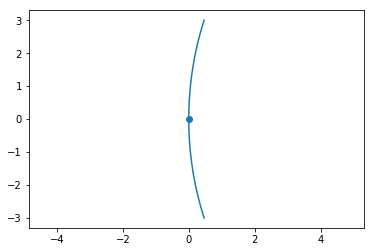

In [6]:
r = np.linspace(-3, 3, 500)
fig, ax = plt.subplots()
plt.axis('equal')
ax=draw_surface(r, surface_0, ax)
plt.show()

### 透镜屈光度图

𝜅  > 0	椭圆 （oblate spheroid），中央屈光度更高，周边逐渐降低，这是一个“负球差”透镜

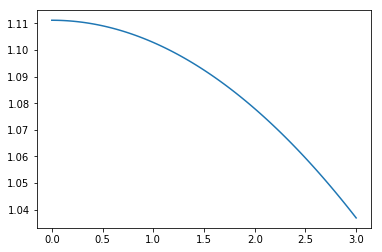

In [7]:
r = np.linspace(0, 3, 100)
fig, ax = plt.subplots()
ax=draw_power(r, surface_0, ax)
plt.show()

# Ray Tracing（光路追迹，光线追踪）

* 光线在均一介质中传播
* 光线在界面上的折射

# 光线在均一介质中传播

直线的方程, 从点$P_0$沿着方向矢量$\vec l$ 传播距离d, 到达点$P(d)$

$$
P(d)=P_0+d  \vec l  
$$
考虑r方向和z方向两个分量
$$
P(d)_r=P_{0r}+d_r  l_r \\
P(d)_z=P_{0z}+d_z  l_z \\
其中 \frac{d_r}{d_z}=\frac{l_r}{l_z}
$$



In [8]:
def travel_in_space(p0,vec_l,dz):
    vec_lz =vec_l[:,0].reshape(-1,1)
    vec_l_in_z=vec_l/vec_lz
    dz=dz.reshape(-1,1)
    pdz=p0+dz*vec_l_in_z
    return pdz

# 折射
$$
n_1 Sin(\theta_1) = n_2 Sin(\theta_2)
$$
参考 https://en.wikipedia.org/wiki/Snell's_law 中的矢量形式


* 入射光方向: $\vec l$
* 曲面的法向量: $\vec n$
* 入射面介质折射率: $n_1$
* 出射面介质折射率: $n_2$

$$
r=n_1/n_2\\
c=-\vec n \cdot \vec l \\
\vec V_{refract}=r\vec l+(rc-\sqrt{1-r^2(1-c^2)})\vec n
$$

In [9]:
def V_refract(vec_l,vec_n,n1,n2):
    r=n1/n2
    if len(vec_l.shape)>1:
        c=np.diag(-np.matmul(vec_n, np.transpose(vec_l))).reshape(-1,1)
    else:
        c=-np.matmul(vec_n.reshape(1,-1),vec_l.reshape(-1,1))    
    V=r*vec_l  + (r*c-np.sqrt(1-r**2*(1-c**2))) * vec_n
    return V/np.linalg.norm(V,axis=1,keepdims=True)

In [10]:
# 测试：
vec_l=np.asarray([[0.707107,-0.707107],[0.707107,-0.707107],[0.707107,-0.707107]])
vec_n=np.asarray([[0,1],[0,1],[0,1]])
n1=1
n2=1/0.9
V_refract(vec_l,vec_n,n1,n2)
# should be:
# [ 0.6364, -0.7714]

array([[ 0.63639614, -0.7713624 ],
       [ 0.63639614, -0.7713624 ],
       [ 0.63639614, -0.7713624 ]])

## 曲面的法向量: $\vec n$

* 简化，仅仅考虑二维

已知有曲面
$$
z=z(r)
$$
则曲面在(z0,r0)位置的法向量: 
$$
\left[ 
\begin{array}{c} 
-1\\ 
\frac{\partial }{\partial r}z\left(r \right) |_{r=r0} 
\end{array} 
\right]
$$

In [11]:
def norm_vec(r,surface_parameter):
    R=surface_parameter["R"]
    kappa=surface_parameter["kappa"]
    a=surface_parameter['a']
    
    V=-1*np.ones([r.shape[0],2])
    V[:,1]=dz(r,surface_parameter)
    return V/np.linalg.norm(V,axis=1,keepdims=True )

### 绘制曲面上的法向量

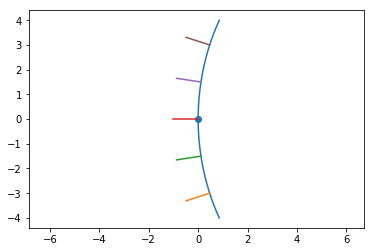

In [12]:
fig, ax = plt.subplots()
plt.axis('equal')
# 绘制曲面
r = np.linspace(-4, 4, 500)
ax=draw_surface(r, surface_0, ax)

# 计算法向量
N=5
rn = np.linspace(-3, 3, N)
norm_v=norm_vec(rn,surface_0)
zn  = surface(rn, surface_0)
zn1 = zn+norm_v[:,0]
rn1 = rn+norm_v[:,1]
for i in range(N):
    ax.plot([zn[i],zn1[i]],[rn[i],rn1[i]])
plt.show()

## 在曲面上折射

In [13]:
def refract_from_surface(p, vec_l,surface_parameter):
    (z0,r0)=surface_parameter["apex"]
    (n1,n2)=surface_parameter['refractive_index']
    r = p[:,1]
    r = r-r0
    vec_n = norm_vec(r,surface_parameter)
    return V_refract(vec_l,vec_n,n1,n2)

# 薄透镜近似

* 薄透镜
    * 直线与曲线的交点，化简成为直线与直线的交点. **这个简化大大降低了运算难度，但也引入很大误差**
* 暂不考虑瞳孔大小

# 已知模型，模拟成像过程

一组平行光，经过两个非球面镜，聚焦到屏幕上。

* 非球面镜0: 镜头垂直于光轴，镜头中心位于光轴上，是一个简单的椭球面
* 非球面镜1: 镜头垂直于光轴，但镜头中心有一定的偏位
* 屏幕：垂直于光轴


In [14]:
surface_0={
    "R":8,
    "kappa": -0.8,
    "a":[0],
    'apex':[0,0],
    'refractive_index':[1,1.3] # before and after
}

surface_1={
    "R":7,
    "kappa": 0.5,
    "a":[0,0],
    'apex':[4,1],
    'refractive_index':[1.3, 1.5] # before and after
}

surface_2={
    "R":1e+10,
    "kappa": 0,
    "a":[0,0],
    'apex':[30,0],
    'refractive_index':[1.5, 1.5] # before and after
}

## Ray Tracing（光路追迹，光线追踪）

追踪每一条光线所走的路径：
* 在均一介质内直线行进：位置改变，方向不变
* 在镜头界面上折射：位置不变，方向改变

依次穿过每一个透镜界面，计算出最终在屏幕上光线的位置

In [15]:
def ray_tracing(light_position_start, light_direction_start, surfaces):

    # 记录光线的位置
    light_postion_list=[light_position_start]
    
    # 从被追踪光线的起始位置和起始方向开始：
    light_position=light_position_start
    light_direction=light_direction_start
    
    for s in surfaces: # 遍历每一个曲面
        #光线在均匀介质内传播，到达该曲面
        dz=s['apex'][0]-light_position[:,0]
        light_position=travel_in_space(light_position,light_direction,dz)
        #光线经过该曲面发生折射
        light_direction=refract_from_surface(light_position, light_direction,s)
        #记录下光线的位置
        light_postion_list.append(light_position)
        
    return light_postion_list

In [16]:
def init_light(N):
    #初始化光线
    light_position_start=-5*np.ones([N,2]) #从z=-5平面开始发出光线
    light_position_start[:,1]= np.linspace(-3, 3, N)
    light_direction_start=np.zeros([N,2])
    light_direction_start[:,0]=1 #方向矢量(1,0)，指向Z轴方向
    return light_position_start,light_direction_start

In [17]:
def draw_ray_tracing(N,surfaces):
    # 绘制出各个曲面的位置：
    fig, ax = plt.subplots()
    plt.axis('equal')
    r = np.linspace(-5, 5, 500)
    for s in surfaces:
        ax=draw_surface(r, s, ax)
    # 光线的起点和方向
#     N=3 # 光线数量
    light_position_start,light_direction_start = init_light(N)

    # 追踪光线，获得光线在各个曲面上经过时的坐标
    light_postion_list=ray_tracing(light_position_start, light_direction_start, surfaces)

    # 绘制出每一根光线
    for i in range(N):
        x=[light_postion[i,0] for light_postion in light_postion_list]
        y=[light_postion[i,1] for light_postion in light_postion_list]
        ax.plot(x,y)
#     ax.set_xlim(28, 32)
#     ax.set_ylim(-2,2)
    plt.show()

/Users/goldengrape/anaconda3/envs/blog/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


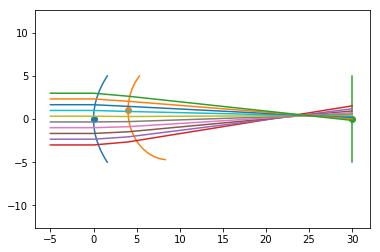

In [18]:
# 绘制ray tracing过程：
draw_ray_tracing(10,[surface_0,surface_1,surface_2])

# 未知模型，求解最佳参数

一组平行光，经过两个非球面镜，聚焦到屏幕上。

* 非球面镜0: 镜头垂直于光轴，镜头中心位于光轴上，是一个简单的椭球面
* 非球面镜1: 镜头垂直于光轴，但镜头中心在一定范围内偏位


## 优化模型

当非球面镜1偏位时，每一条光线最好都能够落在焦点附近，

* 注意：由于镜头偏位，所以焦点并不一定在光轴上，
    * “焦点”，各个光线汇聚的点，或者说，光线的平均位置。
* 简化：每一条光线在屏上的位置 **尽量靠近** 非球面镜1的偏位距离
    * 尽量靠近：到达给定位置的平方和最小
    
优化问题： 求loss_function的最小值：
$$
loss =\sum_{偏位距离=-\Delta}^{+\Delta} \sum_{光线_i =0 }^{N} |光线_i 在屏上位置- 非球面镜_1 的偏位距离|^2
$$

In [19]:
def loss_function(params, light_position_start,light_direction_start  ,data=None):

    spots_on_screen_list=[]
    Delta=0.9
    for apex_r in np.linspace(-Delta,Delta,10): # 将曲面在一定范围内移动
    
        surface_t={
            "R":params["R"],
            "kappa": params["kappa"],
            "a":[params["a4"],params["a6"],params['a8'],params['a10']],
            'apex':[4,apex_r],
            'refractive_index':[1.3, 1.5] # before and after
        }

        surfaces=[surface_0,surface_t,surface_2] 

        # 追踪光线，获得光线在各个曲面上经过时的坐标
        light_postion_list=ray_tracing(light_position_start, light_direction_start, surfaces)
        
        # 希望屏上的光线落在偏位点的附近
        spots_on_screen=(light_postion_list[-1][:,-1]-apex_r)
        spots_on_screen_list.append(np.abs(spots_on_screen))
        
    return spots_on_screen_list

## 优化器

lmfit，scipy优化器的封装，

* 设定好需要优化的参数: $ R, \kappa, a_4,a_6,a_8,a_{10} $ 
* 设定目标loss_function

求解使得loss_function取得最小值的参数表

In [20]:
from lmfit import Minimizer, Parameters, report_fit

# 定义待求解的参数，以及初值，参数的数值范围
params = Parameters()
# add with tuples:(NAME,    初始值,  求解， Min    MAX   EXPR  BRUTE_STEP)
params.add_many(  ('R',     7,      True, 6,     12,   None, None),
                  ('kappa', 0,      True, None,  None, None, None),
                  ('a4',    0,      True, None,  None, None, None),
                  ('a6',    0,      True, None,  None, None, None),
                  ('a8',    0,      True, None,  None, None, None),
                  ('a10',   0,      True, None,  None, None, None),
               )


# 输入N条光线
N=100
light_position_start,light_direction_start = init_light(N)

# 求解参数
minner = Minimizer(loss_function, params, 
                   fcn_args=(light_position_start,light_direction_start,_),
                   nan_policy="propagate")
result = minner.minimize()

# 结果

In [21]:
print("R={:.2f}".format(result.params["R"].value))
print("kappa={:.2f}".format(result.params["kappa"].value))
print("a4={:.2e}".format(result.params["a4"].value))
print("a6={:.2e}".format(result.params["a6"].value))
print("a8={:.2e}".format(result.params["a8"].value))
print("a10={:.2e}".format(result.params["a10"].value))

R=6.02
kappa=1.34
a4=-4.52e-02
a6=-2.28e-03
a8=4.15e-04
a10=-2.71e-05


In [22]:
def get_surface_target(result,apex_r):
    return {
            "R":result.params["R"].value,
            "kappa": result.params["kappa"].value,
            "a":[result.params["a4"].value,
                 result.params["a6"].value,
                 result.params['a8'].value,
                 result.params['a10'].value],
            'apex':[4,apex_r],
            'refractive_index':[1.3, 1.5] # before and after
        }

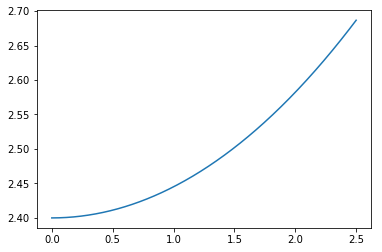

In [26]:
# surface 0 的光焦度曲线
fig, ax = plt.subplots()
r = np.linspace(0, 2.5, 500)
ax=draw_power(r, surface_0, ax)
plt.show()

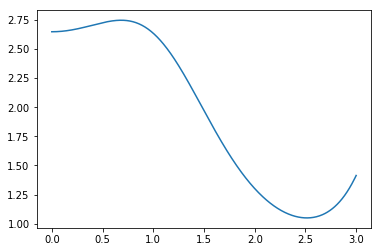

In [27]:
# surface 1 的光焦度曲线
fig, ax = plt.subplots()
# plt.axis('equal')
r = np.linspace(0, 3, 500)
# ax=draw_surface(r, surface_0, ax)
ax=draw_power(r, get_surface_target(result,1), ax)
plt.show()

/Users/goldengrape/anaconda3/envs/blog/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


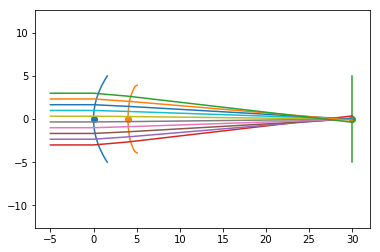

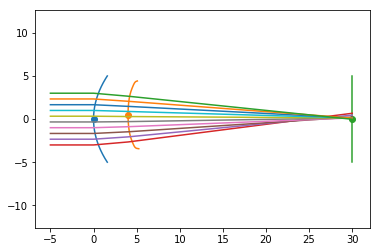

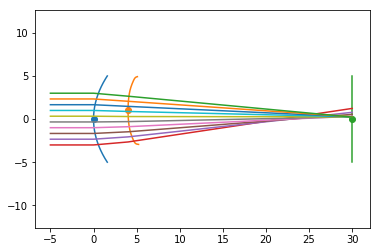

In [28]:
# 不同偏位状态时的聚焦情况
for apex_r in np.linspace(0,1,3):
    draw_ray_tracing(10,[surface_0,get_surface_target(result,apex_r),surface_2])